# A simple Mean Reversion System
Most of the following imports are mainstream, well known Python libraries.

alpha_vantage and fix_yahoo are specialist libraries to download stock data free.  To use alpha_vantage you will need to obtain your own key from the providers https://www.alphavantage.co/

ffn is a specialist library to report trading systems statistics

In [77]:
%matplotlib notebook
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import pandas as pd
from alpha_vantage.timeseries import TimeSeries
# import fix_yahoo_finance as yf
#because the is_list_like is moved to pandas.api.types
pd.core.common.is_list_like = pd.api.types.is_list_like
import ffn
#import pixiedust

## The following two cells can be used to download stock data and then blanked out again once the data has been saved to csv.



In [78]:
asset_sym = 'SPY'.upper()
ts = TimeSeries(key='HK7Q1K6I2EIFKTVL', output_format='pandas')
data, meta_data = ts.get_daily_adjusted(symbol=asset_sym)
#data, meta_data = ts.get_daily_adjusted(symbol='SPY', outputsize='full')

#data = yf.download("SPY", start="2019-01-01", end="2021-03-12")
data.head()

,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient
date,,,,,,,,
2020-11-13,355.27,358.90,354.71,358.10,355.407945,62959429.0,0.0,1.0
2020-11-16,360.98,362.78,359.59,362.57,359.844341,74541138.0,0.0,1.0
2020-11-17,359.97,361.92,358.34,360.62,357.909000,66111009.0,0.0,1.0
2020-11-18,360.91,361.50,356.24,356.28,353.601627,70591299.0,0.0,1.0
2020-11-19,355.60,358.18,354.15,357.78,355.090350,59940947.0,0.0,1.0


In [3]:
#dir(TimeSeries)


In [79]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 100 entries, 2020-11-13 to 2021-04-09
Data columns (total 8 columns):
1. open                 100 non-null float64
2. high                 100 non-null float64
3. low                  100 non-null float64
4. close                100 non-null float64
5. adjusted close       100 non-null float64
6. volume               100 non-null float64
7. dividend amount      100 non-null float64
8. split coefficient    100 non-null float64
dtypes: float64(8)
memory usage: 7.0 KB


## The following line is to create split adjusted Open prices since only the adjusted close is provided:

data['Adj_Open']=data.Open*(data.Adj_Close/data.Close)

Useful if you want to test taking signal from previous close and trading at the next open.

In [80]:


#data.reset_index(inplace=True)
data.rename(columns={'5. adjusted close': 'Adj_Close', '1. open':'Open', '4. close':'Close'}, inplace=True)
data.index.name='Date'

#data.rename(columns={'5. adjusted close': 'Adj_Close', '1. open': 'Open','4. close': 'Close', 'date':'Date'}, inplace=True)
data['Adj_Open']=data.Open*(data.Adj_Close/data.Close)
data.to_csv(asset_sym + '.csv')
#data.to_csv('../data/Stocks/spy.csv')
data.head()

,Open,2. high,3. low,Close,Adj_Close,6. volume,7. dividend amount,8. split coefficient,Adj_Open
Date,,,,,,,,,
2020-11-13,355.27,358.90,354.71,358.10,355.407945,62959429.0,0.0,1.0,352.599220
2020-11-16,360.98,362.78,359.59,362.57,359.844341,74541138.0,0.0,1.0,358.266294
2020-11-17,359.97,361.92,358.34,360.62,357.909000,66111009.0,0.0,1.0,357.263887
2020-11-18,360.91,361.50,356.24,356.28,353.601627,70591299.0,0.0,1.0,358.196820
2020-11-19,355.60,358.18,354.15,357.78,355.090350,59940947.0,0.0,1.0,352.926739


Chart the data to check there are no obvious problems with the split adjusted data.

In [81]:

pricing = pd.read_csv(
            asset_sym + '.csv',
            header=0,
            parse_dates=["Date"],
            #index_col=0,
            usecols=['Date','Adj_Open', 'Adj_Close'])    
stock=pricing.copy()
stock.Adj_Close=stock.Adj_Close.shift(1)

#stock = stock[stock.notnull()]

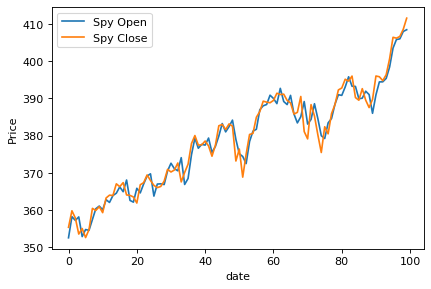

In [82]:
figure(num=None, figsize=(6, 4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(pricing.Adj_Open, label='Spy Open')
plt.plot(pricing.Adj_Close, label='Spy Close')
plt.xlabel('date')
plt.ylabel('Price')
plt.legend();

## Visual inspection of the DataFrame. 

Adjust to see wider and different selection of rows.  e.g pricing.tail(10) shows 
the final ten rows of data. See 10 Minutes to Pandas https://pandas.pydata.org/pandas-docs/stable/10min.html 
or the Pandas Cheat Sheet https://pandas.pydata.org/Pandas_Cheat_Sheet.pdf

In [83]:
pricing.head(),pricing.tail()

(        Date   Adj_Close    Adj_Open
 0 2020-11-13  355.407945  352.599220
 1 2020-11-16  359.844341  358.266294
 2 2020-11-17  357.909000  357.263887
 3 2020-11-18  353.601627  358.196820
 4 2020-11-19  355.090350  352.926739,          Date  Adj_Close  Adj_Open
 95 2021-04-05     406.36    403.46
 96 2021-04-06     406.12    405.76
 97 2021-04-07     406.59    405.94
 98 2021-04-08     408.52    407.93
 99 2021-04-09     411.49    408.39)

## Shift the Adjusted Close down one row 

so that it aligns with the next day's Adjusted Open.  That way we can calculate the signals using the previous day's Close and enter the trade on the next day's Open

In [23]:
#stock=pricing.copy()
#stock.Adj_Close=stock.Adj_Close.shift(1)

#stock.tail()

## Create three or more separate blocks of data for testing. 

Reserve one of these for out of sample testing.

In [24]:
#stock_1=stock.iloc[0:2170].copy()
#stock_2=stock.iloc[2170:4342].copy().reset_index(drop=True)
#stock_3=stock.iloc[4342:6513].copy().reset_index(drop=True) 
#stock_2.head()

## Here is the code for the function which loops through the stock data and executes the trades.  

You can experiment with different parameters such as changing the maximum position size or starting capital.

Experiment with changing references:

1.from both trading and signal generation at the Close; to 

2.signal generation at the Close but trading at the next Open. 

You will not be happy with the result suggesting you may need to automate trading to generate signals and trade intraday so you can execute a trade immediately a signal is given.

In [84]:
# Trade using a simple mean-reversion strategy
def trade(stock, length):

    temp_dict = {}
    # If window length is 0, algorithm doesn't make sense, so exit
    if length == 0:
        return 0

    # Compute rolling means and rolling standard deviation
    #sma and lma are filters to prevent taking long or short positions against the longer term trend
    rolling_window = stock.Adj_Close.rolling(window=length)
    mu = rolling_window.mean()
    sma = stock.Adj_Close.rolling(window=length*1).mean()
    lma = stock.Adj_Close.rolling(window=length * 10).mean()
    std = rolling_window.std()

    #If you don't use a maximum position size the positions will keep on pyramidding.
    #Set max_position to a high number (1000?) to disable this parameter
    #Need to beware of unintended leverage
    max_position = 1
    percent_per_trade = 1.0

    #Slippage and commission adjustment  - simply reduces equity by a percentage guess
    # a setting of 1 means no slippage, a setting of 0.999 gives 0.1% slippage
    slippage_adj = 1

    # Compute the z-scores for each day using the historical data up to that day
    zscores = (stock.Adj_Close - mu) / std

    # Simulate trading
    # Start with your chosen starting capital and no positions
    money = 10000.00
    position_count = 0

    for i, row in enumerate(stock.itertuples(), 0):

        #set up position size so that each position is a fixed position of your account equity
        equity = money + (stock.Adj_Close[i] * position_count)
        if equity > 0:
            fixed_frac = (equity * percent_per_trade) / stock.Adj_Close[i]
        else:
            fixed_frac = 0
        fixed_frac = int(round(fixed_frac))

        #exit all positions if zscore flips from positive to negative or vice versa without going through
        #the neutral zone
        if i > 0:
            if (zscores[i - 1] > 0.5
                    and zscores[i] < -0.5) or (zscores[i - 1] < -0.5
                                               and zscores[i] > 0.5):

                if position_count > 0:
                    money += position_count * stock.Adj_Close[i] * slippage_adj
                elif position_count < 0:
                    money += position_count * stock.Adj_Close[i] * (
                        1 / slippage_adj)
                position_count = 0

        # Sell short if the z-score is > 1 and if the longer term trend is negative
        if (zscores[i] > 1) & (position_count > max_position * -1) & (sma[i] <
                                                                      lma[i]):

            position_count -= fixed_frac
            money += fixed_frac * stock.Adj_Close[i] * slippage_adj

        # Buy long if the z-score is < 1 and the longer term trend is positive
        elif zscores[i] < -1 and position_count < max_position and sma[i] > lma[i]:

            position_count += fixed_frac
            money -= fixed_frac * stock.Adj_Close[i] * (1 / slippage_adj)

        # Clear positions if the z-score between -.5 and .5
        elif abs(zscores[i]) < 0.5:
            #money += position_count * stock.Adj_Close[i]
            if position_count > 0:
                money += position_count * stock.Adj_Close[i] * slippage_adj
            elif position_count < 0:
                money += position_count * stock.Adj_Close[i] * (
                    1 / slippage_adj)
            position_count = 0

        #fill dictionary with the trading results.
        temp_dict[stock.Date[i]] = [
            stock.Adj_Open[i], stock.Adj_Close[i], mu[i], std[i], zscores[i],
            money, position_count, fixed_frac, sma[i], lma[i]
        ]
    #create a dataframe to return for use in calculating and charting the trading results
    pr = pd.DataFrame(data=temp_dict).T
    pr.index.name = 'Date'
    pr.index = pd.to_datetime(pr.index)
    pr.columns = [
        'Open', 'Close', 'mu', 'std', 'zscores', 'money', 'position_count',
        'fixed_frac', 'sma', 'lma'
    ]
    pr['equity'] = pr.money + (pr.Close * pr.position_count)
    #
    return pr

## The next cell calls the function. 

Experiment with different moving averages by altering the number in brackets.

profit = trade(stock, moving_average) runs the back test with the entire price series
profit = trade(stock_1, moving_average) runs the test using only the first third of the data and so forth through 
stock_2 and stock_3

You will need to amend the function "profit.to_csv" to your own raletive or absolute file address

In [85]:
moving_average=10
profit = trade(stock, moving_average)
#profit = profit[np.isfinite(profit).all(1)]

#profit = profit[profit.notnull()]
#mask = profit.notnull()
profit.to_csv('mean_reversion_profit.csv')
#profit.to_csv('../data/mean_reversion_profit.csv')

In [86]:
profit.equity

Date
2020-11-13        NaN
2020-11-16    10000.0
2020-11-17    10000.0
2020-11-18    10000.0
2020-11-19    10000.0
2020-11-20    10000.0
2020-11-23    10000.0
2020-11-24    10000.0
2020-11-25    10000.0
2020-11-27    10000.0
2020-11-30    10000.0
2020-12-01    10000.0
2020-12-02    10000.0
2020-12-03    10000.0
2020-12-04    10000.0
2020-12-07    10000.0
2020-12-08    10000.0
2020-12-09    10000.0
2020-12-10    10000.0
2020-12-11    10000.0
2020-12-14    10000.0
2020-12-15    10000.0
2020-12-16    10000.0
2020-12-17    10000.0
2020-12-18    10000.0
2020-12-21    10000.0
2020-12-22    10000.0
2020-12-23    10000.0
2020-12-24    10000.0
2020-12-28    10000.0
               ...   
2021-02-26    10000.0
2021-03-01    10000.0
2021-03-02    10000.0
2021-03-03    10000.0
2021-03-04    10000.0
2021-03-05    10000.0
2021-03-08    10000.0
2021-03-09    10000.0
2021-03-10    10000.0
2021-03-11    10000.0
2021-03-12    10000.0
2021-03-15    10000.0
2021-03-16    10000.0
2021-03-17    10000.0
2021-

In [72]:
#profit.notnull().all(1,axis=1)
profit.dropna(axis=1,inplace=True)
#profit.notnull()

## Inspect the reults data frame

In [73]:
profit.head() , profit.tail()

(                  Open    money  position_count  fixed_frac
 Date                                                       
 2020-11-13  352.599220  10000.0             0.0         0.0
 2020-11-16  358.266294  10000.0             0.0        28.0
 2020-11-17  357.263887  10000.0             0.0        28.0
 2020-11-18  358.196820  10000.0             0.0        28.0
 2020-11-19  352.926739  10000.0             0.0        28.0,
               Open    money  position_count  fixed_frac
 Date                                                   
 2021-04-05  403.46  10000.0             0.0        25.0
 2021-04-06  405.76  10000.0             0.0        25.0
 2021-04-07  405.94  10000.0             0.0        25.0
 2021-04-08  407.93  10000.0             0.0        25.0
 2021-04-09  408.39  10000.0             0.0        24.0)

## Create a new dataframe 

which contains trhe equity curve as its only column to feed to FFN the stats library

In [74]:
series=profit[['equity']].copy()

KeyError: "['equity'] not in index"

## Stats and Charts

The following charts and stats are allproduced by the FFN Library

In [37]:
stats = series.calc_stats()
stats.display()

Stat                 equity
-------------------  ----------
Start                2020-11-16
End                  2021-04-09
Risk-free rate       0.00%

Total Return         0.00%
Daily Sharpe         -
Daily Sortino        -
CAGR                 0.00%
Max Drawdown         0.00%
Calmar Ratio         -

MTD                  0.00%
3m                   0.00%
6m                   -
YTD                  0.00%
1Y                   -
3Y (ann.)            0.00%
5Y (ann.)            -
10Y (ann.)           -
Since Incep. (ann.)  0.00%

Daily Sharpe         -
Daily Sortino        -
Daily Mean (ann.)    0.00%
Daily Vol (ann.)     0.00%
Daily Skew           0.00
Daily Kurt           -
Best Day             0.00%
Worst Day            0.00%

Monthly Sharpe       -
Monthly Sortino      -
Monthly Mean (ann.)  0.00%
Monthly Vol (ann.)   0.00%
Monthly Skew         0.00
Monthly Kurt         -
Best Month           0.00%
Worst Month          0.00%

Yearly Sharpe        -
Yearly Sortino       -
Yearly Mean    

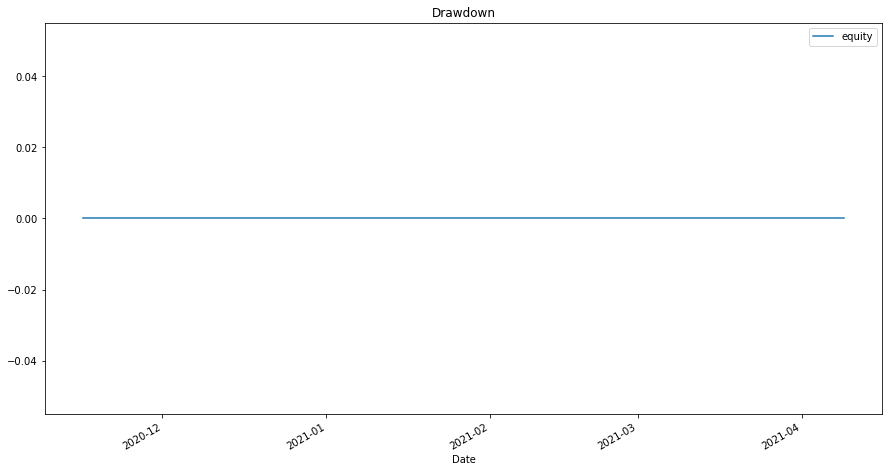

In [30]:
prices =series
ax = stats.prices.to_drawdown_series().plot(figsize=(15, 8),title='Drawdown')

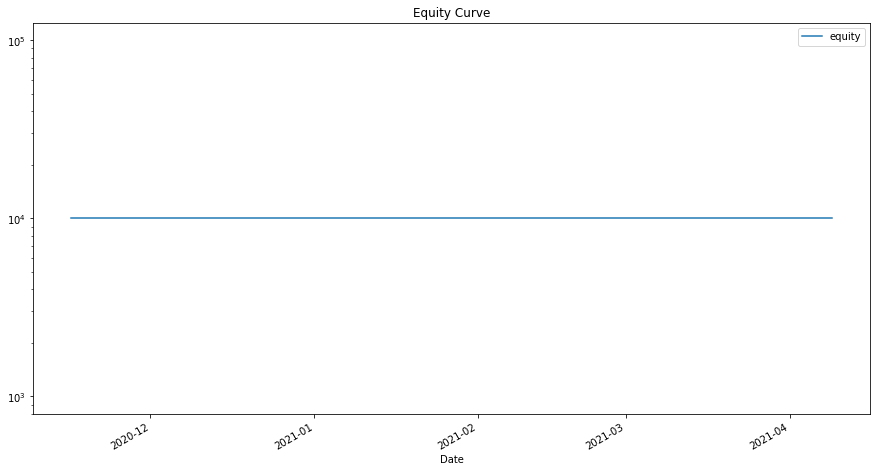

In [17]:
ax = prices.plot(logy=True,figsize=(15, 8),title='Equity Curve')